# load data and do elementary calculations and plots

---

In [1]:
import os
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.49:8786 Dashboard: http://10.148.0.49:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


In [6]:

data_dir = '/home/datawork-lops-osi/data/mit4320/Eta/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['Eta'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].isel(face=1).nbytes / 1e9))

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 4096)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

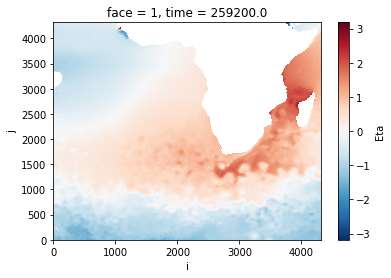

In [7]:
ds['Eta'].isel(face=1, time=0).plot()

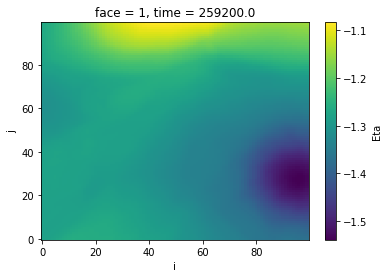

In [8]:
ds['Eta'].isel(face=1, time=0, i=slice(0,100), j=slice(0,100)).plot()

In [9]:
ds['Eta'].isel(face=1, i=0, j=0).mean().compute()

<xarray.DataArray 'Eta' ()>
array(-1.006087, dtype=float32)
Coordinates:
    i        int64 0
    j        int64 0
    face     int64 1
    XC       float32 -37.989582
    YC       float32 -57.001026
    rA       float32 1552802.6
    Depth    float32 3047.2024

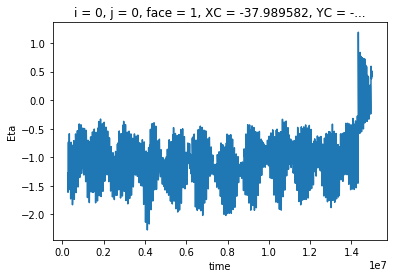

In [10]:
#ds['Eta'].isel(face=1, i=0, j=0, time=slice(0,2000)).plot()
ds['Eta'].isel(face=1, i=0, j=0).plot()
#.chunk({'time': 4096})

CPU times: user 9.24 s, sys: 292 ms, total: 9.54 s
Wall time: 6min 20s


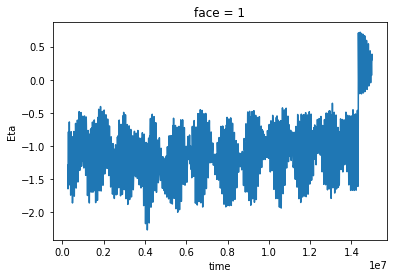

In [11]:
%time ds['Eta'].isel(face=1, i=slice(0,100), j=slice(0,100)).mean(dim=['i','j']).plot()

---

# basic statistics

In [12]:
%time m1 = ds['Eta'].isel(face=1).mean(['time']).persist()

CPU times: user 1.76 s, sys: 4 ms, total: 1.76 s
Wall time: 1.77 s


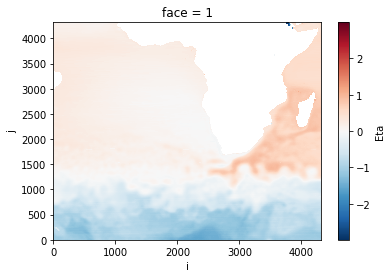

In [13]:
m1.plot()

---

# info, shutdown

In [14]:
client.restart()

Client Scheduler: tcp://10.148.0.49:8786 Dashboard: http://10.148.0.49:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


In [15]:
if dmethod == 2:
    client.close()
    cluster.stop_workers(cluster.jobs)